**Project Introduction & Overview:**

In financial lending, every approved loan represents a calculated risk. If borrowers fail to repay,lenders face direct monetary loss and long-term damage to financial stability. Machine learning offers the opportunity to predict borrower risk before loan approval, reducing defaults and supporting fairness in decision-making.
This project focuses on building classification models that determine whether a borrower is likely to fully repay or default (charged-off) on a personal loan. The primary motivation is to assist financial institutions in making smarter, data-driven lending decisions that minimize risk while ensuring credit acces

s.
This report presents the full analytical workflow: dataset exploration, preprocessing, model development, evaluation using industry-relevant metrics, and interpretation for real-world implementat

t**Objective:**

ion
The business objective centers on identifying high-risk borrowers prior to loan approval.Defaulted loans increase financial loss and undermine the sustainability of consumer lending. As such, the central prediction task is a binary classification:
Will a borrower fully repay the loan, or will the loan de
fault?fault?

In [3]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
loan_data = pd.read_csv("loan_data.csv")
print(loan_data.shape)

(9578, 14)


In [3]:
loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


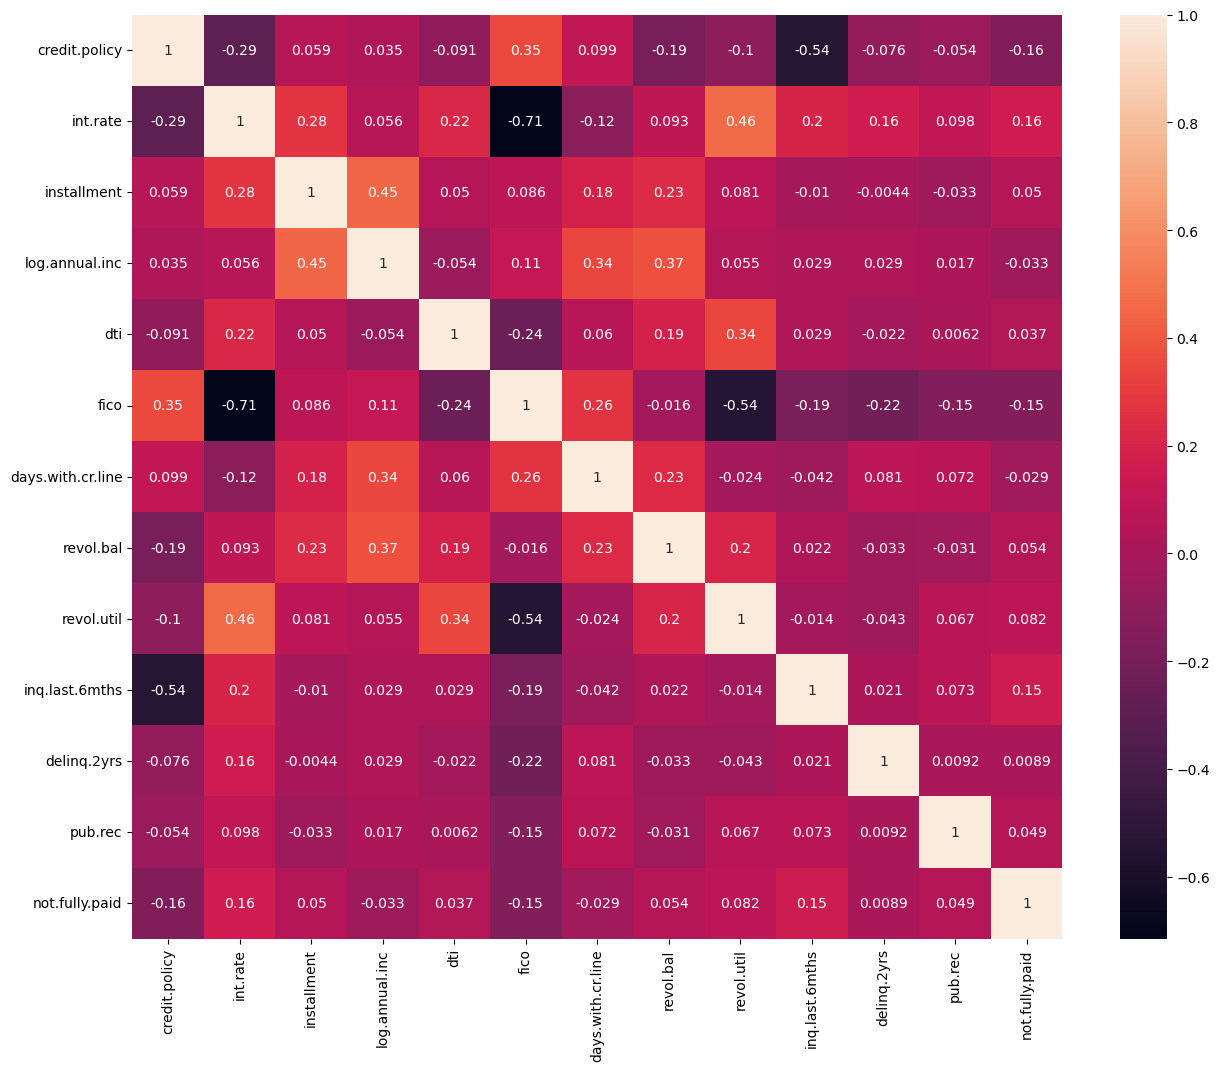

In [13]:
data_corr = loan_data.select_dtypes(include = "number").corr()

#plot heatmap
sns.heatmap(data_corr, annot= True)
plt.rcParams["figure.figsize"]= (15, 12)
plt.show()

In [15]:
#make a clean copy of loan data
loan_df = loan_data.copy()

#drop irrelevant and multicollinear columns
loan_df.drop(columns=["installment", "pub.rec", "revol.bal", "int.rate"], inplace=True)


In [17]:
loan_df.describe()

,credit.policy,log.annual.inc,dti,fico,days.with.cr.line,revol.util,inq.last.6mths,delinq.2yrs,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,10.932117,12.606679,710.846314,4560.767197,46.799236,1.577469,0.163708,0.160054
std,0.396245,0.614813,6.883970,37.970537,2496.930377,29.014417,2.200245,0.546215,0.366676
min,0.000000,7.547502,0.000000,612.000000,178.958333,0.000000,0.000000,0.000000,0.000000
25%,1.000000,10.558414,7.212500,682.000000,2820.000000,22.600000,0.000000,0.000000,0.000000
50%,1.000000,10.928884,12.665000,707.000000,4139.958333,46.300000,1.000000,0.000000,0.000000
75%,1.000000,11.291293,17.950000,737.000000,5730.000000,70.900000,2.000000,0.000000,0.000000
max,1.000000,14.528354,29.960000,827.000000,17639.958330,119.000000,33.000000,13.000000,1.000000


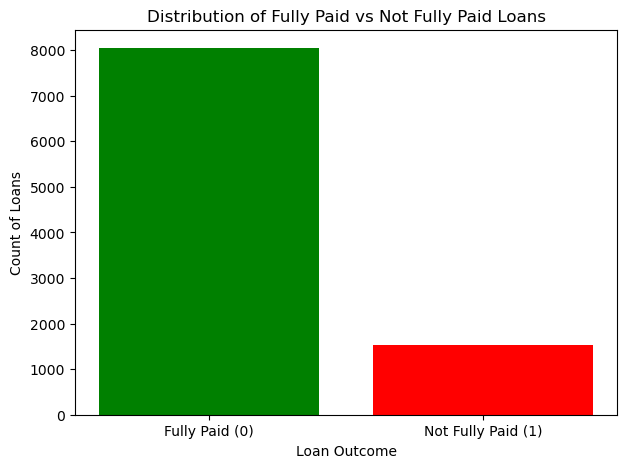

In [285]:
#bar chart for loan outcome distribution
plt.figure(figsize=(7,5))

# count values
counts = loan_data["not.fully.paid"].value_counts().sort_index()

# bar chart
plt.bar(["Fully Paid (0)", "Not Fully Paid (1)"], counts, color=["green", "red"])

plt.title("Distribution of Fully Paid vs Not Fully Paid Loans")
plt.ylabel("Count of Loans")
plt.xlabel("Loan Outcome")
plt.show()

In [21]:
# Display column names, data types, and number of unique values
summary = pd.DataFrame({
    'dtype': loan_df.dtypes,
    'n_unique': loan_df.nunique(),
    'n_missing': loan_df.isna().sum()
})
display(summary)

,dtype,n_unique,n_missing
credit.policy,int64,2,0
purpose,object,7,0
log.annual.inc,float64,1987,0
dti,float64,2529,0
fico,int64,44,0
days.with.cr.line,float64,2687,0
revol.util,float64,1035,0
inq.last.6mths,int64,28,0
delinq.2yrs,int64,11,0
not.fully.paid,int64,2,0


Insights from EDA:

Exploratory analysis revealed meaningful connections between certain borrower attributes and loan outcomes

- Higher debt-to-income ratios and revolving credit utilization showed increased default likelihood
- Lower FICO scores corresponded strongly with missed repayment
-  Certain loan purposes (e.g., small business) had elevated risk levels

These insights validated the relevance ofthe selected features for machine learning classification:

**Models Building**

In [65]:
#import model Libaries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from scipy.stats import randint, uniform

**Data Preprocessing**

In [28]:
#encode categorical column (purpose)
loan_encoded = pd.get_dummies(loan_df, columns=["purpose"], drop_first=True)

In [233]:
#features selection
X = loan_encoded.drop(columns=["not.fully.paid"])
y = loan_encoded["not.fully.paid"]

#train-test split (stratified to handle imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#scale features correctly
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


1. **Logistic Model**

In [235]:
from sklearn.metrics import mean_squared_error,  r2_score, accuracy_score, mean_absolute_error
#instatiate model
model = LogisticRegression(max_iter= 1000, random_state= 42)

#fit model (train)
model.fit(X_train_scaled, y_train)

#predict 
y_pred = model.predict(X_test_scaled)

#Get predicted probabilities for the positive class (1)
y_probs = model.predict_proba(X_test_scaled)[:, 1]

#check models performance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(f"Classification Report: \n {classification_report(y_test, y_pred)}\n")
print(f"ROC-AUC: \n {roc_auc_score(y_test, y_probs)}\n")
print(f"The Mean Absolute Error:\n{(mean_absolute_error(y_test, y_pred))}")

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.99      0.91      1609
           1       0.50      0.03      0.06       307

    accuracy                           0.84      1916
   macro avg       0.67      0.51      0.48      1916
weighted avg       0.79      0.84      0.78      1916


ROC-AUC: 
 0.6673758965752496

The Mean Absolute Error:
0.16022964509394572


**Hyperparameter Tunning of Logistic Regression**

In [218]:
#hyperparameter tuning for logistic regression
from sklearn.model_selection import GridSearchCV

log_params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"],
    "class_weight": ["balanced"]
}

log_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=log_params,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

#fit tuning
log_grid.fit(X_train_scaled, y_train)

#print best params
print("Best Logistic Regression Params:", log_grid.best_params_)


Best Logistic Regression Params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}


In [237]:
#train best logistic regression model
best_log = log_grid.best_estimator_
best_log.fit(X_train_scaled, y_train)

#predict
log_probs = best_log.predict_proba(X_test_scaled)[:, 1]
log_pred = best_log.predict(X_test_scaled)

#metrics
print("\n Logistic Regression:")
print("\n ROC-AUC:", roc_auc_score(y_test, log_probs))
print("\n Accuracy:", accuracy_score(y_test, log_pred))
print(classification_report(y_test, log_pred))



 Logistic Regression:

 ROC-AUC: 0.6685561469178865

 Accuracy: 0.6440501043841336
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      1609
           1       0.24      0.55      0.33       307

    accuracy                           0.64      1916
   macro avg       0.56      0.61      0.54      1916
weighted avg       0.78      0.64      0.69      1916



**Logistic Regression Performance:**

Logistic Regression achieved an accuracy of 0.64 and a ROC-AUC score of 0.669. Most importantly, it detected 55% of defaulting borrowers, showing good awareness of potential risk early on. 

However, a precision score of 0.24 indicates that many borrowers predicted as risky would have actually repaid their loans. In a real lending environment, this could lead to unnecessary rejections and a loss ofprofitable customers.

Overall, Logistic Regression favors safety over accessibility, performing well at flagging risk but struggling to balance fairness in loan approvals.

**2.  Random Forest**

In [239]:
#random forest hyperparameter search space

from sklearn.model_selection import RandomizedSearchCV

rf_param_dist = {
    "n_estimators": randint(200, 600),
    "max_depth": randint(5, 40),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None],
    "class_weight": ["balanced"]
}

#random search cv for random forest
rf_cv = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    random_state=42
)

#fit tuning
rf_cv.fit(X_train_scaled, y_train)
print("Best Random Forest Params:", rf_cv.best_params_)


Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 539}


In [241]:
#train best random forest
best_rf = rf_cv.best_estimator_
best_rf.fit(X_train_scaled, y_train)

#predict
rf_probs = best_rf.predict_proba(X_test_scaled)[:, 1]
rf_pred = best_rf.predict(X_test_scaled)

#metrics
print("\n Random Forest:")
print("\n ROC-AUC:", roc_auc_score(y_test, rf_probs))
print("\n Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


 Random Forest:

 ROC-AUC: 0.6715482738585683

 Accuracy: 0.7687891440501043
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1609
           1       0.30      0.34      0.32       307

    accuracy                           0.77      1916
   macro avg       0.59      0.59      0.59      1916
weighted avg       0.78      0.77      0.77      1916



**Random Forest Performance:**

Random Forest demonstrated the strongest overall performance, achieving 0.77 accuracy and the highest precision among the models. Although it recognized fewer defaulting borrowers (recall =0.34), it was more confident when labeling someone as high-risk, leading to fewer mistaken rejections.

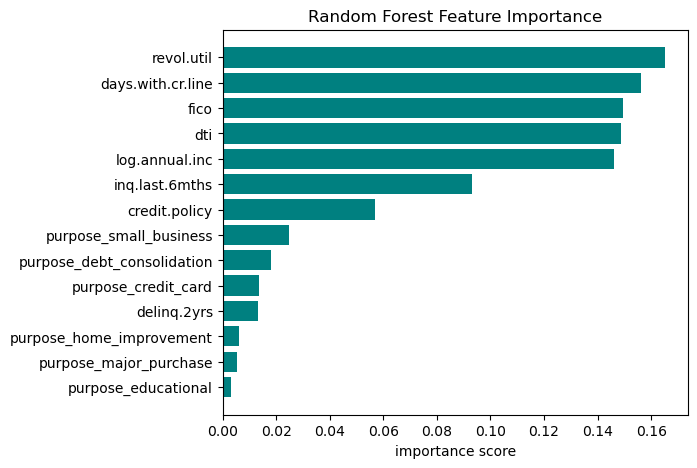

In [262]:
#feature importance for the tuned random forest model

#extract feature names (before scaling)
feature_names = X_train.columns

#importance scores from the model
importances = best_rf.feature_importances_

#create dataframe
feature_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

#plot
plt.figure(figsize=(6,5))
plt.barh(feature_df["feature"], feature_df["importance"], color="teal")
plt.xlabel("importance score")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

Random Forest also provides insight into why a prediction is made. Features such as revolving credit utilization, FICO score, credit history length, and debt-to-income ratio emerged as the most influential factors, consistent with established credit-risk practices.

This alignment with real-world lending criteria makes Random Forest not only effective but also easier to justify in regulated environments.

**3. XGBoost Model**

In [256]:
#compute imbalance ratio
pos = sum(y_train == 1)
neg = sum(y_train == 0)
ratio = neg / pos

#xgboost hyperparameter search space
xgb_params = {
    "n_estimators": randint(200, 600),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "scale_pos_weight": [ratio]   #class imbalance fix
}

xgb_cv = RandomizedSearchCV(
    estimator=XGBClassifier(
        eval_metric='auc',
        random_state=42,
        use_label_encoder=False
    ),
    param_distributions=xgb_params,
    n_iter=30,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    random_state=42
)

#fit tuning
xgb_cv.fit(X_train_scaled, y_train)
print("Best XGBoost Params:", xgb_cv.best_params_)


C:\Users\Maureen Michael\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:54:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Params: {'colsample_bytree': 0.8058265802441404, 'learning_rate': 0.012119891565915222, 'max_depth': 3, 'n_estimators': 248, 'scale_pos_weight': 5.249592169657422, 'subsample': 0.7623873301291946}


In [264]:
#train best xgboost model
best_xgb = xgb_cv.best_estimator_
best_xgb.fit(X_train_scaled, y_train)

#predict
xgb_probs = best_xgb.predict_proba(X_test_scaled)[:, 1]
xgb_pred = best_xgb.predict(X_test_scaled)

#metrics
print("\nXGBoost:")
print("\nROC-AUC:", roc_auc_score(y_test, xgb_probs))
print("\nAccuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))


C:\Users\Maureen Michael\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:58:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost:

ROC-AUC: 0.6646965460975822

Accuracy: 0.6555323590814196
              precision    recall  f1-score   support

           0       0.89      0.67      0.77      1609
           1       0.25      0.55      0.34       307

    accuracy                           0.66      1916
   macro avg       0.57      0.61      0.55      1916
weighted avg       0.79      0.66      0.70      1916



**XGBoost Performance:**

XGBoost offered a similar ability to detect defaults as Logistic Regression (recall = 0.55) but with slightly improved precision (0.25). Although it performed decently in identifying risky borrowers, the overall accuracy of 0.66 shows that it still produces many incorrect predictions.

For a model that is more complex and computationally demanding, the performance trade-off does not provide enough added value for deployment in this case.
It leans toward a cautious lending strategy, but with limited improvement in decision quality.

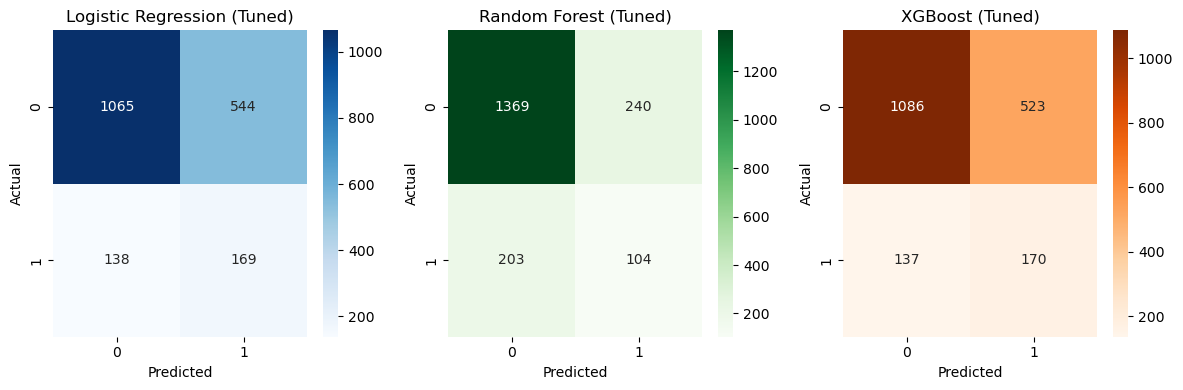

In [266]:
#updated confusion matrix function (works inside subplots)
def plot_cm_ax(ax, y_true, y_pred, title, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

#re-run predictions for hypertuned models
log_pred = best_log.predict(X_test_scaled)
rf_pred = best_rf.predict(X_test_scaled)
xgb_pred = best_xgb.predict(X_test_scaled)

#side-by-side confusion matrix plots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#logistic regression
plot_cm_ax(axes[0], y_test, log_pred, "Logistic Regression (Tuned)", cmap="Blues")

#random forest
plot_cm_ax(axes[1], y_test, rf_pred, "Random Forest (Tuned)", cmap="Greens")

#xgboost
plot_cm_ax(axes[2], y_test, xgb_pred, "XGBoost (Tuned)", cmap="Oranges")

#adjust layout
plt.tight_layout()
plt.show()

**Observations:**

From the 3 models, Random Forest performed better in predicting loan defaulter with 77% accuracy and Roc-Auc of 0.67

Hence, it will be used to predict multiple outputs and predict new x-values

**Using Random Forest to Predict Multiple Outputs**

In [274]:
#targets for dual-model
targets_new = {
    "default": loan_encoded["not.fully.paid"],
    "approval": loan_encoded["credit.policy"]
}
#loop through both targets
for name, y in targets_new.items():

    #split y using same index
    y_train_new = y.loc[X_train_new.index]
    y_test_new  = y.loc[X_test_new.index]

    #build model
    model_new = RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        class_weight="balanced",
        random_state=42
    )
    
    #fit model (IMPORTANT!)
    model_new.fit(X_train_scaled_new, y_train_new)

    #store model + predictions
    rf_models_new[name] = model_new
    rf_preds_new[name]  = model_new.predict(X_test_scaled_new)
    rf_probs_new[name]  = model_new.predict_proba(X_test_scaled_new)[:, 1]

    #print results
    print("\nRandom Forest:", name)
    print("ROC-AUC:", roc_auc_score(y_test_new, rf_probs_new[name]))
    print("Accuracy:", accuracy_score(y_test_new, rf_preds_new[name]))



Random Forest: default
ROC-AUC: 0.6462170935474352
Accuracy: 0.80741127348643

Random Forest: approval
ROC-AUC: 0.9738425539027243
Accuracy: 0.9749478079331941


**Predicting if new borrowers will default or not**

In [278]:
#3 borrowers data (low, high, medium risk)
new_data = {
    "log.annual.inc": [11.2, 9.0, 10.4],        
    "dti": [12, 55, 22],                        
    "fico": [780, 540, 660],                  
    "days.with.cr.line": [4100, 500, 2600],     
    "revol.util": [20, 99, 60],                 
    "inq.last.6mths": [0, 10, 3],               
    "delinq.2yrs": [0, 6, 1],               

    #purpose dummies (ensure same columns as training data)
    "purpose_credit_card":          [0, 0, 1],
    "purpose_debt_consolidation":   [1, 0, 0],
    "purpose_educational":          [0, 1, 0],
    "purpose_home_improvement":     [0, 0, 0],
    "purpose_major_purchase":       [0, 0, 0],
    "purpose_small_business":       [0, 0, 0]
}

new_X = pd.DataFrame(new_data)
new_X.head()


,log.annual.inc,dti,fico,days.with.cr.line,revol.util,inq.last.6mths,delinq.2yrs,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,11.2,12,780,4100,20,0,0,0,1,0,0,0,0
1,9.0,55,540,500,99,10,6,0,0,1,0,0,0
2,10.4,22,660,2600,60,3,1,1,0,0,0,0,0


In [280]:
#scale
new_X_scaled = scaler.transform(new_X)

#predict default
default_prob = rf_models_new["default"].predict_proba(new_X_scaled)[:, 1]
default_pred = (default_prob >= 0.30).astype(int)

#predict approval
approval_pred = rf_models_new["approval"].predict(new_X_scaled)
approval_prob = rf_models_new["approval"].predict_proba(new_X_scaled)[:, 1]

#display
results = pd.DataFrame({
    "borrower": ["A", "B", "C"],
    "pred_default": default_pred,
    "prob_default": default_prob,
    "pred_approval": approval_pred,
    "prob_approval": approval_prob
})

print(results)


  borrower  pred_default  prob_default  pred_approval  prob_approval
0        A             0      0.165399              1       0.977828
1        B             1      0.308940              0       0.100000
2        C             1      0.389156              1       0.909020


**Final Takes:**

All three models achieved similar ROC-AUC scores (around 0.66–0.67), meaning they performed comparably at ranking borrowers by risk. The key differences appear in how they balance wrong approvals versus wrong rejections:
- Logistic Regression and XGBoost are quick to mark borrowers as risky, which helps catch defaults but can block too many good customers.
- Random Forest is more selective and approves safe borrowers more accurately, which helps sustain lending volume while still reducing losses.

Because of this balance between risk control and business value, Random Forest was selected as the most practical final model for deployment.

Final Model Deployment and Use Case Illustration.

To illustrate how RandomForest model supports lending decisions, hypothetical borrowers were evaluated based on their predicted default probability.
Instead of simply approving or rejecting, the output enables more flexible actions such as conditional approvals or interest adjustments. This supports responsible credit access while still managing potential losses.

**Recommendations:**

To strengthen the model’s real-world effectiveness, continued monitoring and threshold adjustments are recommended as lending conditions change. Adding new behavioral features,such as repayment trends over time, could improve the model’s ability to identify true high-risk borrowers.


**Conclusion:**

This project demonstrated how machine learning can complement traditional lending strategies by offering early insights into borrower risk. Among the evaluated models, Random Forest delivered the most balanced and operationally useful performance. By supporting informed approvals and targeted risk controls, the model provides a strong foundation for smarter, data-driven loan decision-making.